In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'decoding_by_ncells_dhpc'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'plot_scores_compare2', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'plot_scores_vs_ncells', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_cellreg', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_across', ignoring (u

In [5]:
import h5py

#def load_decoding_data(animals, session, notebook, cellreg=False):
##     patterns = dict(zip(animals, [ut.load_variable('patterns_evs', '../%s/%s/notebooks/autorestore/%s/'%(ani, session, notebook))
##                                     for ani in animals]))
##     labels = dict(zip(animals, [ut.load_variable('labels', '../%s/%s/notebooks/autorestore/%s/'%(ani, session, notebook))
##                                         for ani in animals]))
#    
#    patterns = ut.load_all_animals_vars('patterns_evs', animals, session, notebook,)
#    labels = ut.load_all_animals_vars('labels', animals, session, notebook)
#    if cellreg:
#        cellregs = {}
#        for ani in animals:
#            try:
#                cellregs[ani] = load_cellreg(ani)
#            except IOError:
#                raise Exception("Cannot find cellreg data for %s."%ani)
#        for k, v in patterns.items():
#            patterns[k] = patterns[k][:, cellregs[k][session]]
#    else:
#        cellregs = None
#
#    return patterns, labels


def do_decoding_combined_within(patterns, labels, n_loops=15, ncells=None, cellreg=False, n_steps=15, **args):
    
    scores = np.r_[[do_test_within(patterns, labels, n_cells=ncells, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(20, total_n, n_steps).astype(int)], n_loops)
    else:
        ncells = np.repeat(np.r_[np.linspace(20, ncells, n_steps).astype(int)], n_loops)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):
#     which_train = range(90)
#     which_test = range(90)

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
        
def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

def do_test_across(patterns_train, labels_train, patterns_test, labels_test, **args):
    x, y, _, _ = combine_train_test_patterns(patterns_train, labels_train, train_test_split=1, **args)
    xT, yT, _, _ = combine_train_test_patterns(patterns_test, labels_test, train_test_split=1, **args)
    decoder.fit(x, t)
    return decoder.score(xT, yT)

def plot_scores_compare2(score1, score2, sess1='pre',sess2='post',colors=['b', 'r',], labels=True, chance=None, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 2))
    values = [score1*100, score2*100]
    pt.plot_bars(values, ax=ax, colors=colors, stderr=True)
    if chance is not None:
        ax.hlines(chance, -0.5, 2-0.5, linestyles='dashed')

    ax.set_xticks(range(2))
    ax.set_xticklabels([sess1,sess2], rotation=30)
    
    ax.set_ylim(0,100)

    if labels:
        ax.set_ylabel('Decoding Performance (%)')
    pvs = []
    pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]

    # if savefig:
    # fig.savefig('../img/%s__bars.pdf'%NOTEBOOK_NAME)
    # np.savetxt('../img/%s__bars.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')
    
    return ax

def plot_scores_vs_ncells(ncells, scores, labels=True, dot_color=(1, 0.7, 0.7), color='r', chance=None, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 1))
    ax.plot(ncells, scores*100, 'o', ms=2, mew=0, color=dot_color, zorder=0)
    ax.errorbar(ncells[::n_loops], scores.reshape(-1, n_loops).mean(1)*100,
                np.std(scores.reshape(-1, n_loops), 1)*100,
                color=color)
    ax.set_ylim(0, 100)
    
    if labels:
        ax.set_xlabel("No. of Cells")
        ax.set_ylabel("Performance")

    if chance is not None:
        xmin, xmax, _, _  = ax.axis()
        ax.hlines(chance, xmin, xmax, linestyles='dashed', lw=0.5, color='k')

    # if savefig:
    # fig.savefig('../img/%s__bars.pdf'%NOTEBOOK_NAME)
    # np.savetxt('../img/%s__bars.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')
    return ax

def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict
#try:
#    filepath = '../data/cellreg_preVSpost.mat'
#    arrays = {}
#    f = h5py.File(filepath)
#    cellreg_map = np.array(f['cell_registered_struct']['cell_to_index_map'])-1
#    keep = np.prod(cellreg_map, 0)>0
#    cellregs_preVSpost = dict(zip(['pre_post', 'post_pre'], cellreg_map.T[keep].T.astype(int)))
#except:
#    print 'not there'


In [6]:
expo_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
pre_animals =  'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
post_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
post_hiatus_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'

In [7]:
delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

delta_t15s = 1
t_start15s = -5.5 
t_stop15s = 10.5  

delta_t2s = 2
t_start2s = -4
t_stop2s  = 10

In [8]:
sessions = 'expo','pre','post','post_hiatus'
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[32, 16, 16, 7]


In [9]:
for tb in bins:
    for sess in sessions:
        try:
            exec("patterns_%s_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(tb,sess,sess,tb,sess,sess))
            exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                             '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,sess,sess))
        except:
            print 'nope %s %s'%(tb,sess)

In [10]:
for sess in sessions:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]):
            exec('patterns_%s_%s_%s = {}'%(tb,sess,t))
            for ani in eval('%s_animals'%sess):
                try:
                    #print sess, tb, ani,
                    exec("patterns_%s_%s_%s['%s'] = patterns_%s_%s['%s'][%s]"%(tb,sess,t,ani,tb,sess,ani,t))
                except:
                    print 'NOPE',sess, tb, ani
                    continue

In [11]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')
    
cv = LeaveOneOut()

In [12]:
bins

['05s', '1s', '15s', '2s']

In [13]:
%%time
n_loops=20
for tb,i,s in zip(bins[:2],range(len(bins[:2])),[10,5]):
    for t in range(s,bin_ranges[i]-s): # only take bins around CS and US, to speed up anlaysis
        exec('scores_%s_%s = {}'%(tb,t))
        exec('ncells_%s_%s = {}'%(tb,t))
        exec('scores_%s_%s_ncells = {}'%(tb,t))
        for sess in sessions:
            exec("scores_%s_%s[sess],ncells_%s_%s[sess],scores_%s_%s_ncells[sess] = do_decoding_combined_within(patterns_%s_%s_%s,\
                  labels_%s,n_loops=n_loops,ncells=280,classes=range(1,5))"%(tb,t,tb,t,tb,t,tb,sess,t,sess))
    print tb,"DONE;  "

05s DONE;  
1s DONE;  
CPU times: user 26min 21s, sys: 1.57 s, total: 26min 23s
Wall time: 26min 21s


scores_vhpc_post, ncells, scores_vhpc_post_ncells = do_decoding_combined_within(patterns_evs_1s_post,labels_post
                                                                 n_loops=2, classes=range(1, 5))
scores_vhpc_pre, ncells, scores_vhpc_pre_ncells = do_decoding_combined_within(,
                                                                 n_loops=2, classes=range(1, 5))

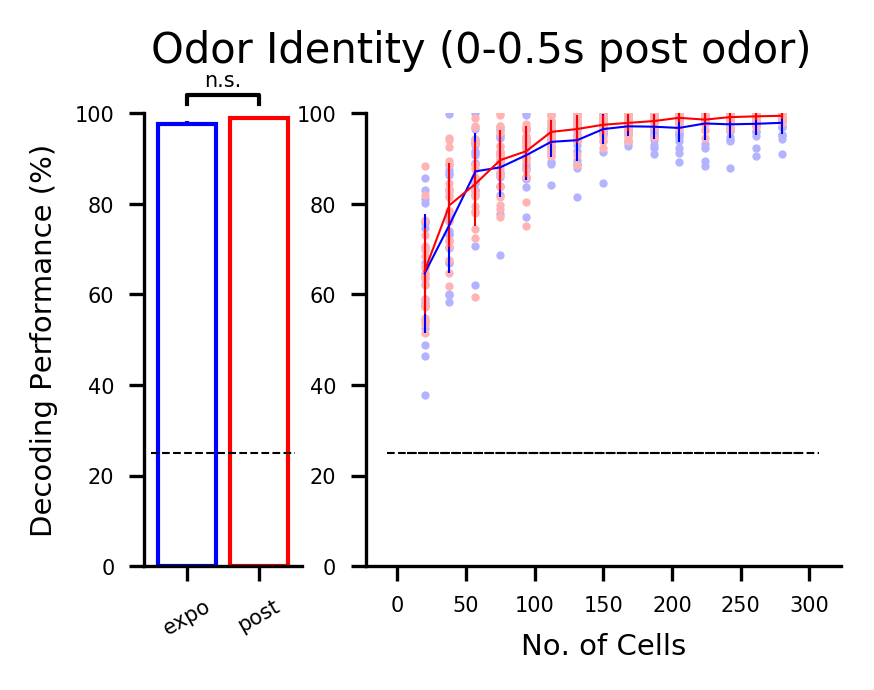

In [14]:
sess1='expo'
sess2='post'
tb=11

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("scores_05s_%s[sess1]"%tb), eval("scores_05s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("ncells_05s_%s[sess1]"%tb), eval("scores_05s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_05s_%s[sess2]"%tb), eval("scores_05s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Odor Identity (0-0.5s post odor)", fontsize=10,y=1.02)

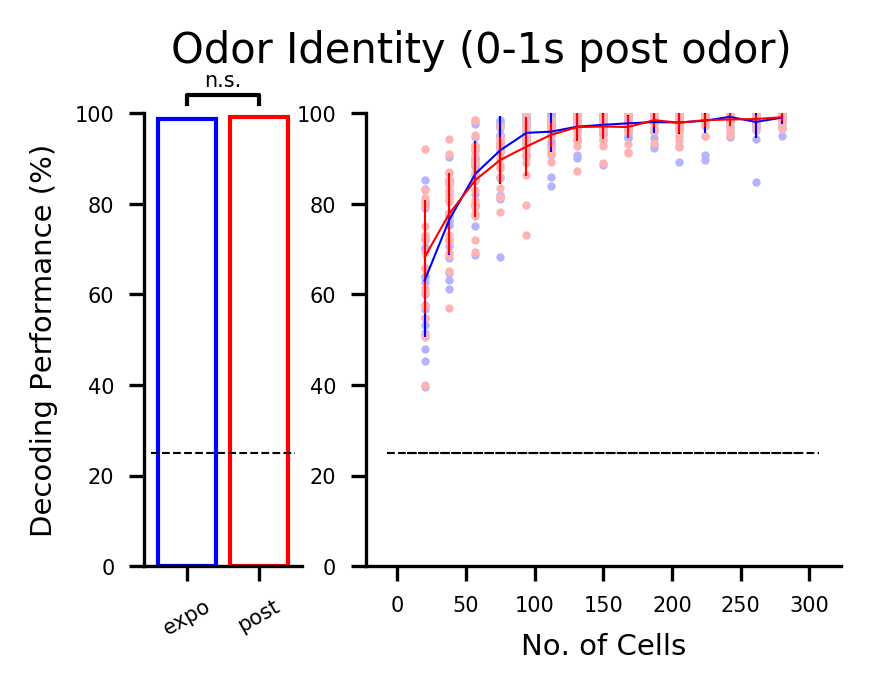

In [15]:
sess1='expo'
sess2='post'
tb=5

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("scores_1s_%s[sess1]"%tb), eval("scores_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("ncells_1s_%s[sess1]"%tb), eval("scores_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s[sess2]"%tb), eval("scores_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Odor Identity (0-1s post odor)", fontsize=10,y=1.02)

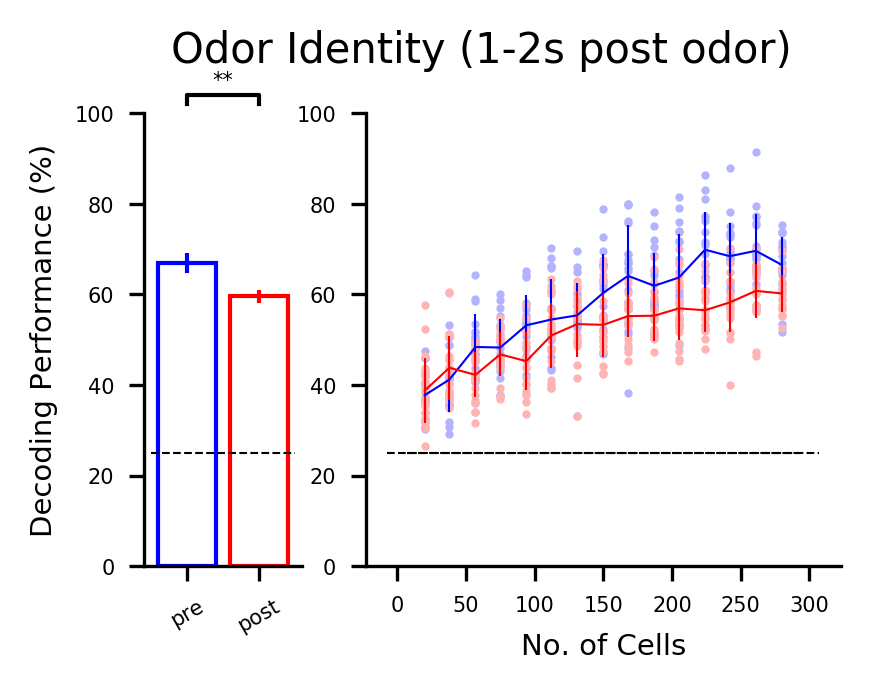

In [16]:
sess1='pre'
sess2='post'
tb=6

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("scores_1s_%s[sess1]"%tb), eval("scores_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("ncells_1s_%s[sess1]"%tb), eval("scores_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s[sess2]"%tb), eval("scores_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Odor Identity (1-2s post odor)", fontsize=10,y=1.02)

## CS+/CS-

In [17]:
relabel = {1:0, 2:0, 3:1, 4:1}

In [18]:
%%time
n_loops=20
for tb,i,s in zip(bins[:2],range(len(bins[:2])),[10,5]):
    for t in range(s,bin_ranges[i]-s): # only take bins around CS and US, to speed up anlaysis
        exec('scores_cspm_%s_%s = {}'%(tb,t))
        exec('ncells_cspm_%s_%s = {}'%(tb,t))
        exec('scores_cspm_%s_%s_ncells = {}'%(tb,t))
        for sess in sessions:
            exec("scores_cspm_%s_%s[sess],ncells_%s_%s[sess],scores_cspm_%s_%s_ncells[sess] = do_decoding_combined_within(patterns_%s_%s_%s,\
                  labels_%s,n_loops=n_loops,ncells=280,classes=range(1,5),relabel=relabel)"%(tb,t,tb,t,tb,t,tb,sess,t,sess))
    print tb,"DONE;  "

05s DONE;  
1s DONE;  
CPU times: user 22min 9s, sys: 1.53 s, total: 22min 10s
Wall time: 22min 9s


scores_cspm_vhpc_post, ncells, scores_cspm_vhpc_post_ncells = do_decoding_combined_within(vhpc_post_animals, 'post', 'decoding_four_odors',
                                                                 n_loops=2, classes=range(1, 5), relabel=relabel)
scores_cspm_vhpc_pre, ncells, scores_cspm_vhpc_pre_ncells = do_decoding_combined_within(vhpc_pre_animals, 'pre', 'decoding_four_odors',
                                                                 n_loops=2, classes=range(1, 5), relabel=relabel)

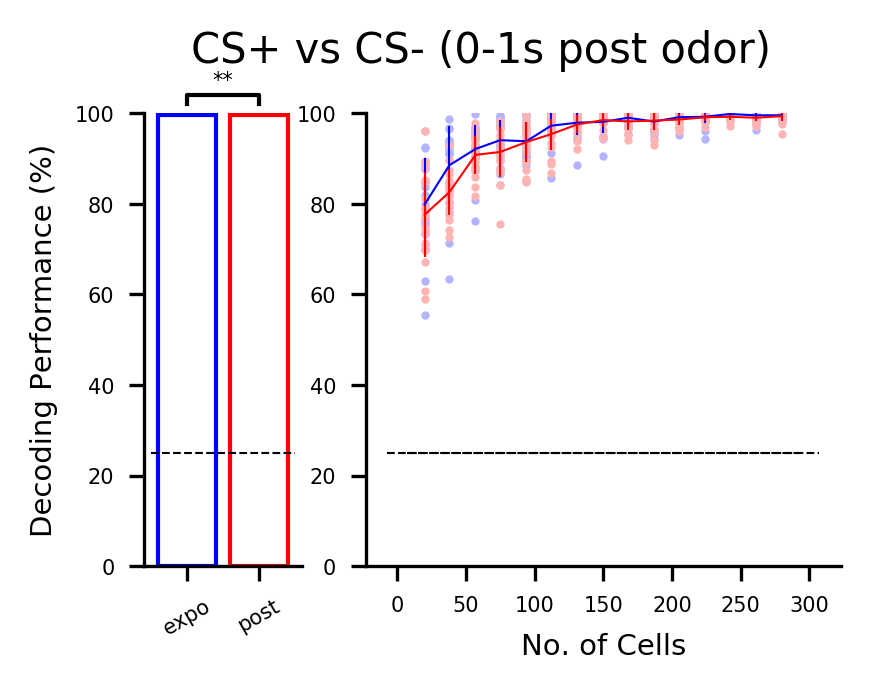

In [19]:
sess1='expo'
sess2='post'
tb=5

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("scores_cspm_1s_%s[sess1]"%tb), eval("scores_cspm_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("ncells_1s_%s[sess1]"%tb), eval("scores_cspm_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s[sess2]"%tb), eval("scores_cspm_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("CS+ vs CS- (0-1s post odor)", fontsize=10,y=1.02)

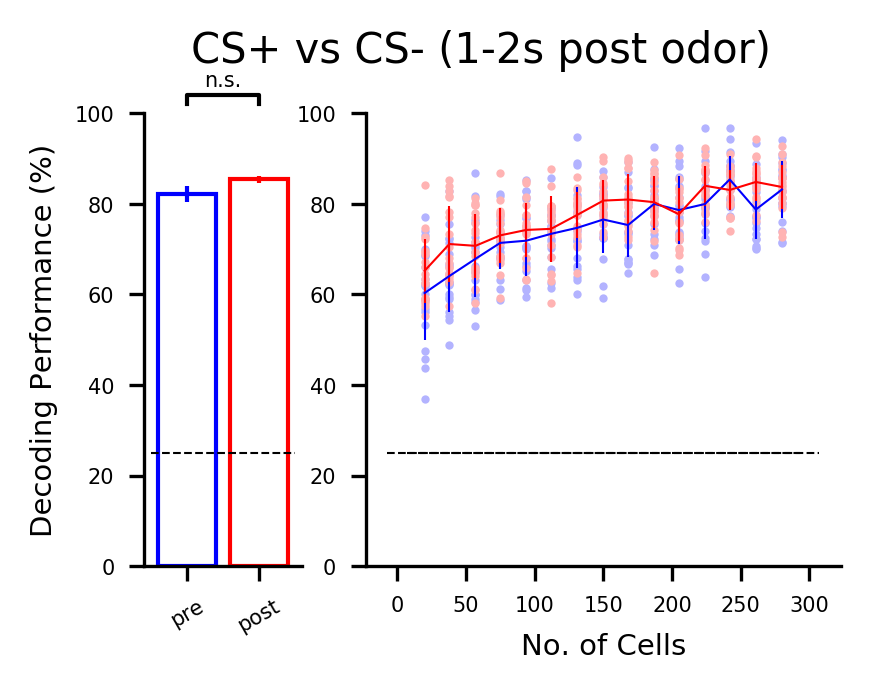

In [20]:
sess1='pre'
sess2='post'
tb=6

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("scores_cspm_1s_%s[sess1]"%tb), eval("scores_cspm_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("ncells_1s_%s[sess1]"%tb), eval("scores_cspm_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s[sess2]"%tb), eval("scores_cspm_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("CS+ vs CS- (1-2s post odor)", fontsize=10,y=1.02)

# Cellreg

In [21]:
#get patterns of cells registered across all 3 sessions
for tb in bins:
    for sess in sessions[1:]:
        exec("cellreg_patterns_%s_%s_reg_w_all = dict(zip(%s_animals, [ut.load_variable('patterns_evs_reg_%s_%s_all',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(tb,sess,sess,tb,sess,sess))

In [22]:
for sess in sessions[1:]:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]):
            exec('cellreg_patterns_%s_%s_%s = {}'%(tb,sess,t))
            for ani in eval('%s_animals'%sess):
                exec("cellreg_patterns_%s_%s_%s['%s'] = cellreg_patterns_%s_%s_reg_w_all['%s'][%s]"%(tb,sess,t,ani,tb,sess,ani,t))

In [23]:
%%time
n_loops=20
for tb,i,s in zip(bins[:2],range(len(bins[:2])),[10,5]):
    for t in range(s,bin_ranges[i]-s): # only take bins around CS and US, to speed up anlaysis
        exec('cellreg_scores_%s_%s = {}'%(tb,t))
        exec('cellreg_ncells_%s_%s = {}'%(tb,t))
        exec('cellreg_scores_%s_%s_ncells = {}'%(tb,t))
        for sess in sessions[1:]:
            exec("cellreg_scores_%s_%s[sess],cellreg_ncells_%s_%s[sess],cellreg_scores_%s_%s_ncells[sess] = do_decoding_combined_within(cellreg_patterns_%s_%s_%s,\
                  labels_%s,n_loops=n_loops,ncells=102,classes=range(1,5))"%(tb,t,tb,t,tb,t,tb,sess,t,sess))
    print tb,"DONE;  "

05s DONE;  
1s DONE;  
CPU times: user 16min 5s, sys: 1.03 s, total: 16min 6s
Wall time: 16min 5s


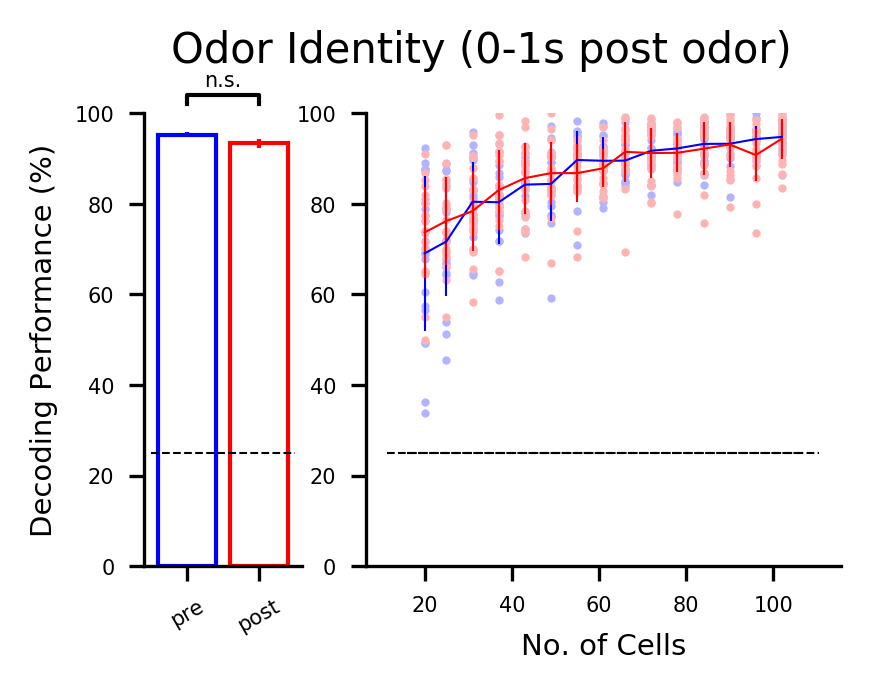

In [24]:
sess1='pre'
sess2='post'
tb=5

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("cellreg_scores_1s_%s[sess1]"%tb), eval("cellreg_scores_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess1]"%tb), eval("cellreg_scores_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess2]"%tb), eval("cellreg_scores_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("Odor Identity (0-1s post odor)", fontsize=10,y=1.02)

In [25]:
%%time
n_loops=20
for tb,i,s in zip(bins[:2],range(len(bins[:2])),[10,5]):
    for t in range(s,bin_ranges[i]-s): # only take bins around CS and US, to speed up anlaysis
        exec('cellreg_scores_cspm_%s_%s = {}'%(tb,t))
        exec('cellreg_ncells_%s_%s = {}'%(tb,t))
        exec('cellreg_scores_cspm_%s_%s_ncells = {}'%(tb,t))
        for sess in sessions[1:]:
            exec("cellreg_scores_cspm_%s_%s[sess],cellreg_ncells_%s_%s[sess],cellreg_scores_cspm_%s_%s_ncells[sess] = do_decoding_combined_within(cellreg_patterns_%s_%s_%s,\
                  labels_%s,n_loops=n_loops,ncells=102,classes=range(1,5),relabel=relabel)"%(tb,t,tb,t,tb,t,tb,sess,t,sess))
    print tb,"DONE;  "

05s DONE;  
1s DONE;  
CPU times: user 15min 20s, sys: 988 ms, total: 15min 21s
Wall time: 15min 19s


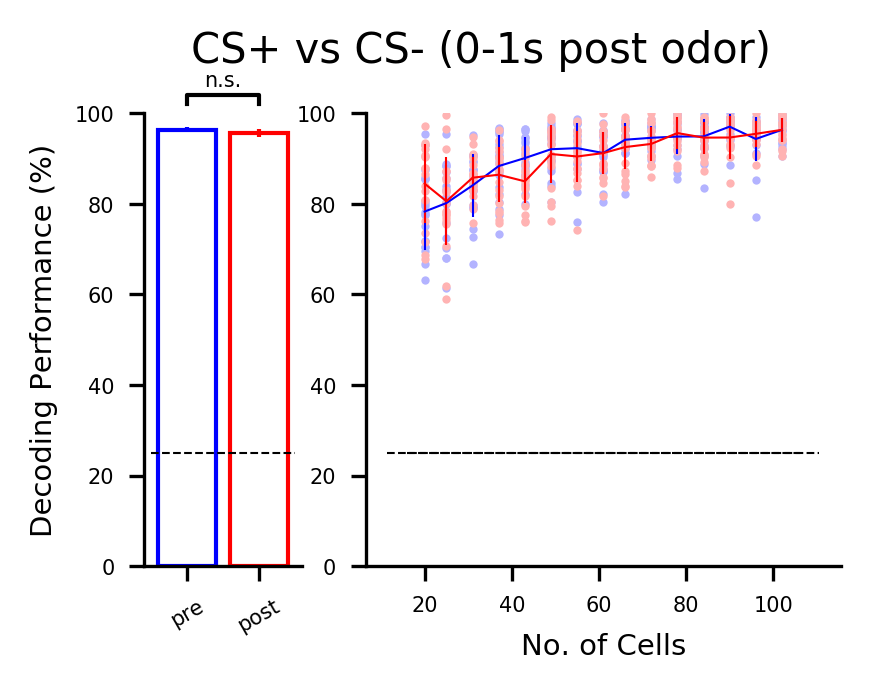

In [26]:
sess1='pre'
sess2='post'
tb=5

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("cellreg_scores_cspm_1s_%s[sess1]"%tb), eval("cellreg_scores_cspm_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess1]"%tb), eval("cellreg_scores_cspm_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess2]"%tb), eval("cellreg_scores_cspm_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("CS+ vs CS- (0-1s post odor)", fontsize=10,y=1.02)

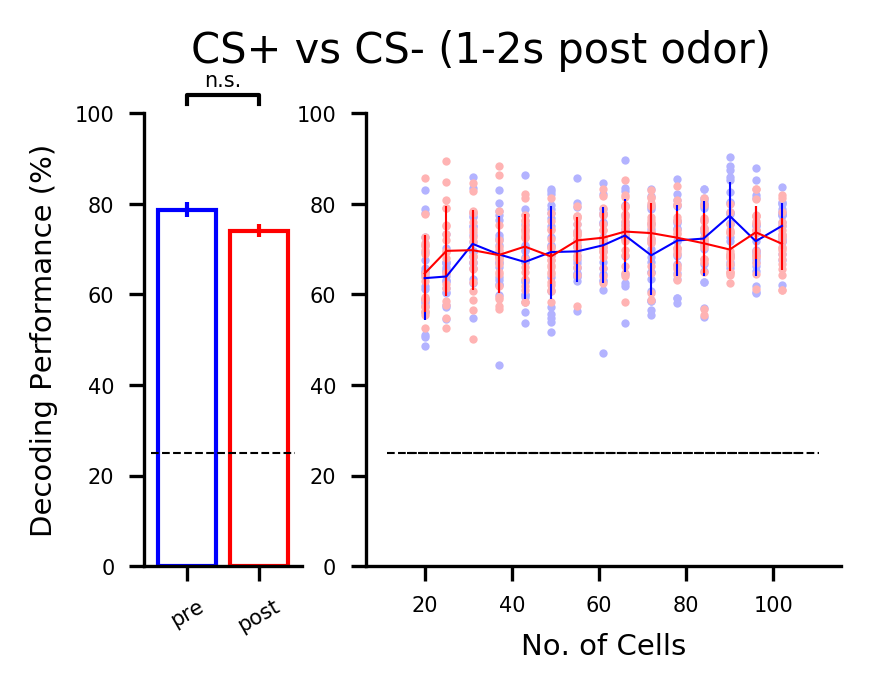

In [27]:
sess1='pre'
sess2='post'
tb=6

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("cellreg_scores_cspm_1s_%s[sess1]"%tb), eval("cellreg_scores_cspm_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess1]"%tb), eval("cellreg_scores_cspm_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess2]"%tb), eval("cellreg_scores_cspm_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("CS+ vs CS- (1-2s post odor)", fontsize=10,y=1.02)

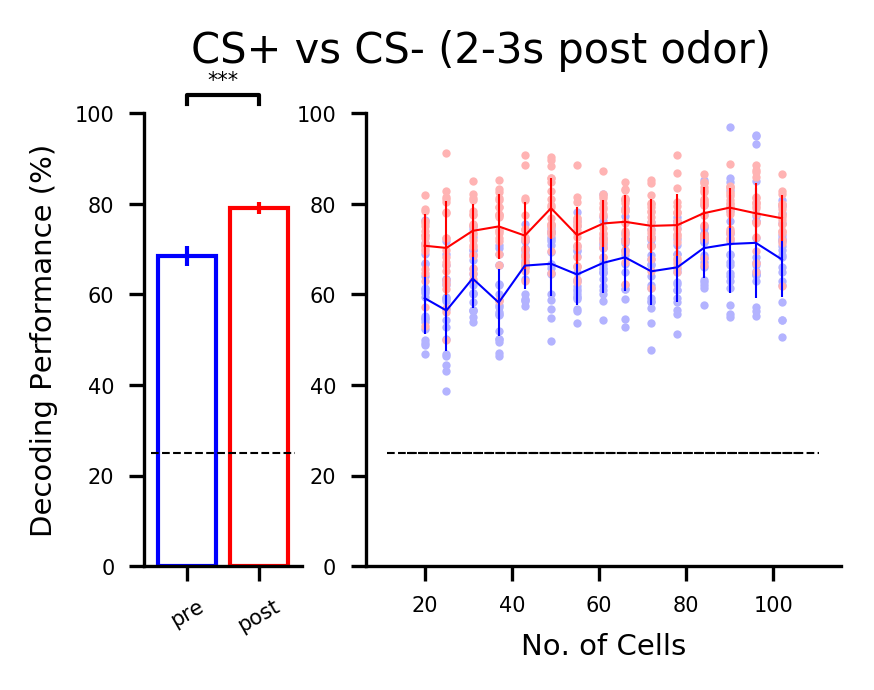

In [28]:
sess1='pre'
sess2='post'
tb=7

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("cellreg_scores_cspm_1s_%s[sess1]"%tb), eval("cellreg_scores_cspm_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess1]"%tb), eval("cellreg_scores_cspm_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess2]"%tb), eval("cellreg_scores_cspm_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("CS+ vs CS- (2-3s post odor)", fontsize=10,y=1.02)

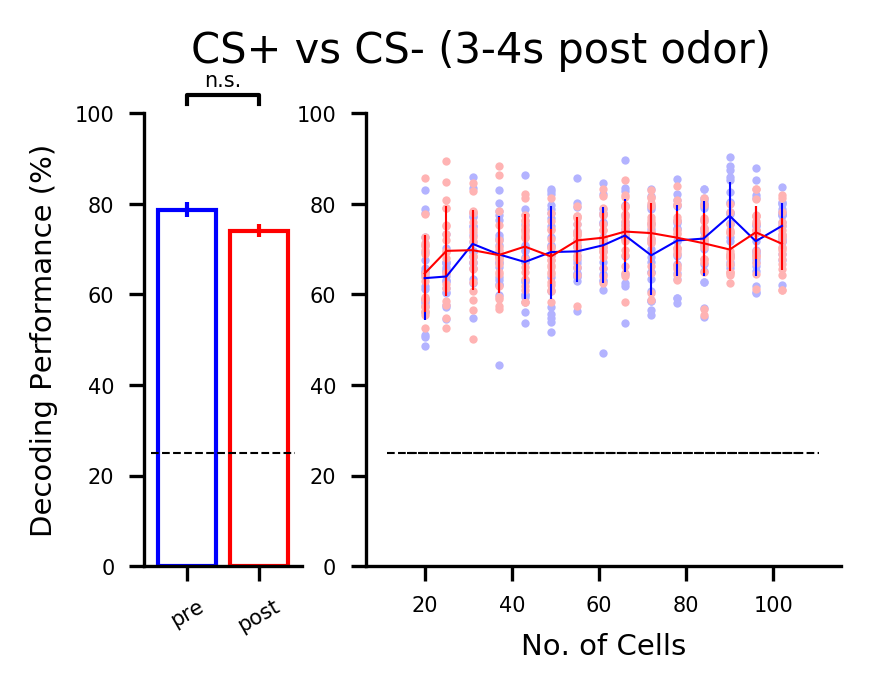

In [36]:
sess1='pre'
sess2='post'
tb=6

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("cellreg_scores_cspm_1s_%s[sess1]"%tb), eval("cellreg_scores_cspm_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=25, ax=axs[0])

plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess1]"%tb), eval("cellreg_scores_cspm_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=25, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("cellreg_ncells_1s_%s[sess2]"%tb), eval("cellreg_scores_cspm_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=25, labels=False)

axs[1].set_xlabel("No. of Cells")

fig.suptitle("CS+ vs CS- (3-4s post odor)", fontsize=10,y=1.02)

# Valence

patterns, labels = load_decoding_data(vhpc_post_animals, 'post', 'decoding_four_odors')
relabel_train = {1:0, 2:-1, 3:1, 4:-1}
relabel_test = {1:-1, 2:0, 3:-1, 4:1}
x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5),
                                           relabel=relabel_train, relabel_test=relabel_test)
decoder.fit(x, y)
decoder.score(xT, yT)

In [30]:
def do_decoding(patterns,labels,n_cells=None,n_loops=15,n_steps=15):

    def do_it(patterns,labels,n_cells=n_cells):
        scores = []
        
        relabel_train = {1:0, 2:-1, 3:1, 4:-1}
        relabel_test = {1:-1, 2:0, 3:-1, 4:1}
        x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5), n_cells=n_cells,
                                                   relabel=relabel_train, relabel_test=relabel_test)
        decoder.fit(x, y)
        scores.append(decoder.score(xT, yT))
        
        relabel_train = {1:0, 2:-1, 3:-1, 4:1}
        relabel_test = {1:-1, 2:0, 3:1, 4:-1}
        x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5), n_cells=n_cells,
                                                   relabel=relabel_train, relabel_test=relabel_test)
        decoder.fit(x, y)
        scores.append(decoder.score(xT, yT))
        
        relabel_train = {1:-1, 2:0, 3:1, 4:-1}
        relabel_test = {1:0, 2:-1, 3:-1, 4:1}
        x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5), n_cells=n_cells,
                                                   relabel=relabel_train, relabel_test=relabel_test)
        decoder.fit(x, y)
        scores.append(decoder.score(xT, yT))
        
        relabel_train = {1:-1, 2:0, 3:-1, 4:1}
        relabel_test = {1:0, 2:-1, 3:1, 4:-1}
        x, y, xT, yT = combine_train_test_patterns(patterns, labels, classes=range(1, 5), n_cells=n_cells,
                                                   relabel=relabel_train, relabel_test=relabel_test)
        decoder.fit(x, y)
        scores.append(decoder.score(xT, yT))
        
        return scores

    scores = np.r_[[do_it(patterns,labels,n_cells=n_cells) for i in range(n_loops)]].flatten()
    
    if n_cells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(20, total_n, n_steps).astype(int)], n_loops)
    else:
        ncells = np.repeat(np.r_[np.linspace(20, n_cells, n_steps).astype(int)], n_loops)
        
    scores_ncells = np.r_[[np.mean(do_it(patterns, labels, n_cells=n)) 
                                        for n in ncells]]

    
    return scores, ncells, scores_ncells

In [31]:
%%time
n_loops=20
for tb,i,s in zip(bins[:2],range(len(bins[:2])),[10,5]):
    for t in range(s,bin_ranges[i]-s): # only take bins around CS and US, to speed up anlaysis
        exec('scores_valence_%s_%s = {}'%(tb,t))
        exec('ncells_valence_%s_%s = {}'%(tb,t))
        exec('scores_valence_%s_%s_ncells = {}'%(tb,t))
        for sess in sessions:
            exec("scores_valence_%s_%s[sess],ncells_%s_%s[sess],scores_valence_%s_%s_ncells[sess] = do_decoding(patterns_%s_%s_%s,\
                  labels_%s,n_loops=n_loops,n_cells=280,n_steps=15)"%(tb,t,tb,t,tb,t,tb,sess,t,sess))
    print tb,"DONE;  "

05s DONE;  
1s DONE;  
CPU times: user 1h 15min 15s, sys: 5.23 s, total: 1h 15min 20s
Wall time: 1h 15min 15s


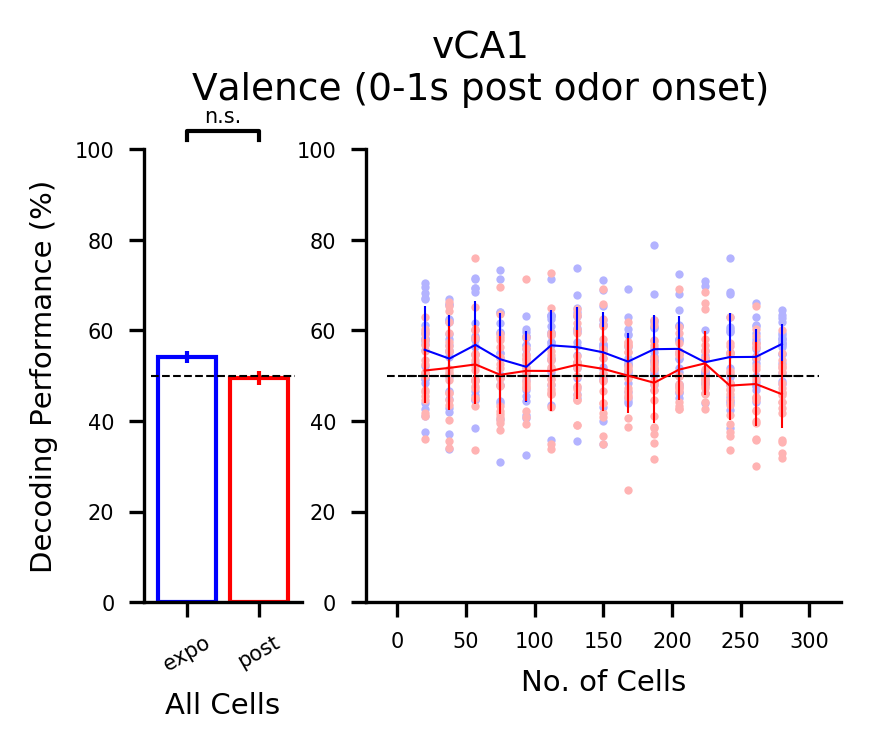

In [32]:
sess1='expo'
sess2='post'
tb=5

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("scores_valence_1s_%s[sess1]"%tb), eval("scores_valence_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=50, ax=axs[0])

plot_scores_vs_ncells(eval("ncells_1s_%s[sess1]"%tb), eval("scores_valence_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=50, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s[sess2]"%tb), eval("scores_valence_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=50, labels=False)
axs[0].set_xlabel("All Cells")
axs[1].set_xlabel("No. of Cells")

fig.suptitle("vCA1\nValence (0-1s post odor onset)", fontsize=9,y=1.08)
fig.savefig('../figures/%s_odor_valence.pdf'%NOTEBOOK_NAME)

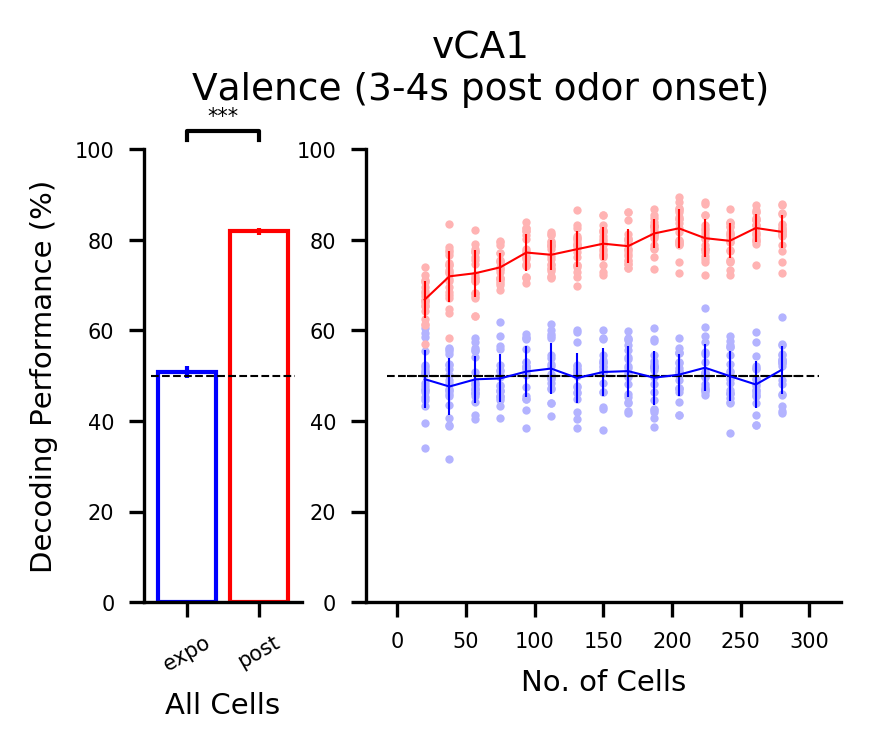

In [33]:
sess1='expo'
sess2='post'
tb=8

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2(eval("scores_valence_1s_%s[sess1]"%tb), eval("scores_valence_1s_%s[sess2]"%tb), sess1=sess1,sess2=sess2, chance=50, ax=axs[0])

plot_scores_vs_ncells(eval("ncells_1s_%s[sess1]"%tb), eval("scores_valence_1s_%s_ncells"%tb)[sess1], dot_color=(0.7, 0.7, 1), color='b', chance=50, ax=axs[1], labels=False)
plot_scores_vs_ncells(eval("ncells_1s_%s[sess2]"%tb), eval("scores_valence_1s_%s_ncells"%tb)[sess2], ax=axs[1], chance=50, labels=False)
axs[0].set_xlabel("All Cells")
axs[1].set_xlabel("No. of Cells")

fig.suptitle("vCA1\nValence (3-4s post odor onset)", fontsize=9,y=1.08)
fig.savefig('../figures/%s_trace_valence.pdf'%NOTEBOOK_NAME)

In [34]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'np'. Skipping...
